# Importing Datasets
In this step, we load the resumes and job descriptions, and prepare the required libraries for TF-IDF vectorization and cosine similarity.

In [20]:
!pip install python-docx
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from google.colab import drive
drive.mount('/content/drive')

# Load the resume and job description datasets
cvs = pd.read_csv('Data/Resumes.csv')
jobs = pd.read_csv('Data/job_descriptions (1).csv')

from google.colab import files
uploaded = files.upload()

from docx import Document

def extract_text_from_docx(uploaded_file_path):
    try:
        doc = Document(uploaded_file_path)
        full_text = []
        for para in doc.paragraphs:
            full_text.append(para.text)
        return '\n'.join(full_text)
    except Exception as e:
        return f"Error reading {uploaded_file_path}: {e}"

# Replace with your uploaded filenames
resume_path = "/content/sample_resume.docx"
job_path = "/content/sample_job_description.docx"

resume_text = extract_text_from_docx(resume_path)
job_text = extract_text_from_docx(job_path)


# Preview the data
print("CVs Preview:")
display(cvs.head())

# print("Job Descriptions Preview:")
# display(jobs.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving sample_resume.docx to sample_resume.docx
Saving sample_job_description.docx to sample_job_description.docx
CVs Preview:


,Name,Email,About Me,Skills,Experience
0,John Thompson,john.thompson@example.com,Experienced Machine Learning Engineer with str...,"Python, TensorFlow, Scikit-learn, Data Preproc...","Worked on projects requiring Python, TensorFlo..."
1,Jared Strickland,jared.strickland@example.com,Experienced Software Tester with strong backgr...,"Manual Testing, Test Cases, Bug Reports, Regre...","Worked on projects requiring Manual Testing, T..."
2,Harold Dixon,harold.dixon@example.com,Experienced Business Intelligence Analyst with...,"Power BI, Data Warehousing, ETL, SQL, Dashboar...","Worked on projects requiring Power BI, Data Wa..."
3,Shannon Ward,shannon.ward@example.com,Experienced Digital Marketing Specialist with ...,"SEO, Google Ads, Content Marketing, Analytics,...","Worked on projects requiring SEO, Google Ads, ..."
4,Miguel Thompson,miguel.thompson@example.com,Experienced UX/UI Designer with strong backgro...,"Figma, Sketch, Wireframing, User Research, Ado...","Worked on projects requiring Figma, Sketch, Wi..."


#Preprocessing the Text
In this step we clean and tokenize text fields like "About Me", "Skills", and "Experience" from the resumes, as well as "Required Skills" and "Responsibilities" from job descriptions. So we can later use those for our algorithms

In [21]:
import re

# ⬇️ Stopwords to ignore during comparison
stop_words = set([
    "i", "me", "my", "myself", "we", "our", "you", "your", "he", "she", "it",
    "this", "that", "is", "was", "are", "were", "be", "been", "am", "do", "does",
    "did", "the", "a", "an", "and", "or", "but", "of", "at", "by", "for", "with",
    "about", "against", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under"
])

# ⬇️ Clean and tokenize any text field
def clean_text(text):
    text = str(text).lower()
    words = re.findall(r'\b[a-z]+\b', text)
    return [word for word in words if word not in stop_words]

# 🧼 Apply cleaning to resumes and jobs
cvs['text'] = cvs[['About Me', 'Skills', 'Experience']].astype(str).agg(' '.join, axis=1)
jobs['text'] = jobs[['Required Skills', 'Responsibilities']].astype(str).agg(' '.join, axis=1)

#TF-IDF Matrix and Cosine Similarity
We now create a TF-IDF matrix for all resumes and job descriptions, then compare them using cosine similarity.

In [22]:
vectorizer = TfidfVectorizer(stop_words='english')

tfidf_jobs = vectorizer.fit_transform(jobs['text'])
tfidf_cvs = vectorizer.transform(cvs['text'])

similarity_matrix = cosine_similarity(tfidf_cvs, tfidf_jobs)

#Matching


In [23]:
# Matching resumes to job descriptions using TF-IDF similarity
best_scores = similarity_matrix.max(axis=1)
best_job_indices = similarity_matrix.argmax(axis=1)
best_titles = [jobs.loc[i, 'Job Title'] for i in best_job_indices]

cvs['Best Match Score'] = best_scores.round(2)
cvs['Best Match Job Title'] = best_titles

def classify(score):
    if score >= 0.6:
        return "Perfect Match"
    elif score >= 0.3:
        return "Partial Match"
    else:
        return "Mismatch"

cvs['Predicted Category'] = cvs['Best Match Score'].apply(classify)

#About Me Checking

In [24]:
def generate_about_me_suggestion(about_me_text, matching_jobs_df):
    suggestions = []

    about_me_text = str(about_me_text).lower()

    # If matching_jobs_df is empty or just a string, skip comparison
    if isinstance(matching_jobs_df, str) or matching_jobs_df is None:
        combined_requirements = ""
    else:
        combined_requirements = ' '.join(matching_jobs_df['Responsibilities'].astype(str).values).lower()

    # Check for useful soft skills in job responsibilities
    soft_skills = ['team', 'communication', 'initiative', 'creative', 'adaptable', 'detail', 'leadership', 'goal']

    missing_skills = [skill for skill in soft_skills if skill in combined_requirements and skill not in about_me_text]

    if len(about_me_text.split()) < 30:
        suggestions.append("Try expanding your 'About Me' with more details about your background and career goals.")

    if missing_skills:
        suggestions.append(f"Consider including soft skills like {', '.join(missing_skills[:3])} — they're important for jobs you match.")

    if not suggestions:
        return "Your 'About Me' section looks professional and aligns well with the job you're targeting."
    else:
        return ' '.join(suggestions)

#AI Resume Suggestions (GPT-3.5)
In this step, we send each resume and job description to OpenAI and receive personalized, natural-sounding suggestions for how the user can improve their resume to better match the job.

In [25]:
def generate_fake_suggestion(cv_text, job_title, job_skills, job_responsibilities, match_category):
    # Tokenize and clean
    cv_words = set(cv_text.lower().split())
    job_words = set((job_skills + " " + job_responsibilities).lower().split())

    cv_keywords = {w for w in cv_words if w not in ENGLISH_STOP_WORDS and len(w) > 2}
    job_keywords = {w for w in job_words if w not in ENGLISH_STOP_WORDS and len(w) > 2}

    missing = list(job_keywords - cv_keywords)
    missing_top = ", ".join(missing[:5]) if missing else ""

    # Generate suggestion based on match level
    if match_category == "Perfect Match":
        return f"Your resume aligns very well with the '{job_title}' role. Just be sure to tailor your experiences clearly for maximum impact."
    elif match_category == "Partial Match":
        return f"You’re close to a great match for '{job_title}'. Consider adding skills or keywords like: {missing_top}."
    else:
        return f"To better align with the '{job_title}' position, try including more relevant experience or keywords such as: {missing_top}."


In [26]:
def extract_about_me(text):
    lines = text.split('\n')
    about_me_lines = []
    start = False

    for line in lines:
        line = line.strip()
        if line.lower().startswith("about me"):
            start = True
            continue
        elif start and (line.lower().startswith("skills") or line.lower().startswith("experience")):
            break
        elif start:
            about_me_lines.append(line)

    return ' '.join(about_me_lines).strip()


In [27]:
def extract_job_title(text):
    for line in text.split('\n'):
        if line.lower().startswith("job title"):
            return line.split(":")[-1].strip()
    return "Your Uploaded Job"

#Checking uploaded files


In [29]:
def extract_comma_separated_skills(text):
    lines = text.split("\n")
    skills = []

    for i, line in enumerate(lines):
        if "skills" in line.lower():
            # Find the next non-empty line with comma-separated skills
            for j in range(i + 1, min(i + 5, len(lines))):
                if "," in lines[j]:
                    extracted = [s.strip().title() for s in lines[j].split(",") if s.strip()]
                    skills.extend(extracted)
                    break
            break  # Stop after the first match

    return skills



cv_skills = extract_comma_separated_skills(resume_text)
job_required_skills_section = job_text.split("Responsibilities")[0]
job_skills = extract_comma_separated_skills(job_required_skills_section)

# Normalization & comparison
cv_set = set(skill.lower() for skill in cv_skills)
job_set = set(skill.lower() for skill in job_skills)

matched = sorted(cv_set & job_set)
missing = sorted(job_set - cv_set)

# Display results
checked = [f"✅ {skill.title()}" for skill in matched]
missing_out = [f"❌ {skill.title()}" for skill in missing]
decorated_suggestion = "\n".join(checked + missing_out)
match_percent = round((len(matched) / len(job_set)) * 100) if job_set else 0

my_about_me = extract_about_me(resume_text)
job_title = extract_job_title(job_text)

print("📌 Skill Match Breakdown:\n", "\n".join([f"✅ {s.title()}" for s in matched] + [f"❌ {s.title()}" for s in missing]))
print(f"\n🎯 Match Percentage: {round((len(matched)/len(job_set))*100) if job_set else 0}%")
print("\n🧠 About Me Extracted:\n", my_about_me)

#-------------------------------------------------------------
def generate_natural_skill_suggestion(job_title, missing_skills, match_percent):
    if not missing_skills:
        return f"Your resume is an excellent match for '{job_title}'. All required skills are present!"
    elif match_percent >= 60:
        phrasing = "You're close to a great match"
    elif match_percent >= 30:
        phrasing = "You're somewhat aligned"
    else:
        phrasing = "There's room for improvement"

    skills_suggestion = ', '.join(missing_skills)
    return f"{phrasing} for '{job_title}'. You could improve your chances by learning or adding: {skills_suggestion}."

# ✅ Updated About Me Suggestion Function
def generate_about_me_suggestion(about_me_text, matching_jobs_df):
    suggestions = []

    about_me_text = str(about_me_text).lower()
    combined_requirements = ' '.join(matching_jobs_df['Responsibilities'].astype(str).values).lower()

    # Check for useful soft skills in job responsibilities
    soft_skills = ['team', 'communication', 'initiative', 'creative', 'adaptable', 'detail', 'leadership', 'goal']

    missing_skills = [skill for skill in soft_skills if skill in combined_requirements and skill not in about_me_text]

    if len(about_me_text.split()) < 30:
        suggestions.append("Try expanding your 'About Me' with more details about your background and career goals.")

    if missing_skills:
        suggestions.append(f"Consider including soft skills like {', '.join(missing_skills[:3])} — they're important for jobs you match.")

    if not suggestions:
        return "Your 'About Me' section looks great and aligns well with the jobs you're targeting."
    else:
        return ' '.join(suggestions)
print("\n📌 Skills & Content Suggestion:")
print(generate_natural_skill_suggestion(job_title, [skill.title() for skill in missing], match_percent))

print("\n📌 About Me Suggestion:")
dummy_job_df = pd.DataFrame([{
    'Responsibilities': "Must demonstrate leadership, communication, and teamwork in dynamic environments."
}])

print(generate_about_me_suggestion(my_about_me, dummy_job_df))

📌 Skill Match Breakdown:
 ✅ Python
✅ Sql
❌ Critical Thinking
❌ Data Analysis
❌ Problem Solving

🎯 Match Percentage: 40%

🧠 About Me Extracted:
 I am a data enthusiast with a background in statistics and strong communication skills. I enjoy working in teams and solving real-world problems with data.

📌 Skills & Content Suggestion:
You're somewhat aligned for 'Junior Data Analyst'. You could improve your chances by learning or adding: Critical Thinking, Data Analysis, Problem Solving.

📌 About Me Suggestion:
Try expanding your 'About Me' with more details about your background and career goals. Consider including soft skills like leadership — they're important for jobs you match.


#Visualizing Results
Let's display a pie chart showing the distribution of match types.

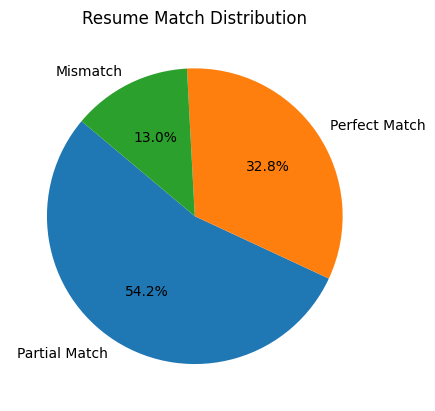

In [30]:
import matplotlib.pyplot as plt

cvs['Predicted Category'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=140, title='Resume Match Distribution'
)
plt.ylabel('')
plt.show()

#MySkillsMatch


In [31]:
def analyze_cv_and_suggest(input_skills, input_about_me, jobs_df, tfidf_vectorizer):
    input_text = ' '.join(input_skills).lower()
    input_vec = tfidf_vectorizer.transform([input_text])

    job_texts = jobs_df[['Required Skills', 'Responsibilities']].astype(str).agg(' '.join, axis=1)
    job_vecs = tfidf_vectorizer.transform(job_texts)

    # Compute similarity
    similarities = cosine_similarity(input_vec, job_vecs)[0]
    jobs_df['Match Score'] = similarities.round(2)

    # Classify
    def classify(score):
        if score >= 0.6:
            return "Perfect Match"
        elif score >= 0.3:
            return "Partial Match"
        else:
            return "Mismatch"

    jobs_df['Category'] = jobs_df['Match Score'].apply(classify)
    top_matches = jobs_df.sort_values(by='Match Score', ascending=False).head(5)

    # Generate About Me suggestions
    about_me_feedback = generate_about_me_suggestion(input_about_me, top_matches)

    return top_matches[['Job Title', 'Match Score', 'Category']], about_me_feedback

#Test for About Me and Skills


🎯 Based on your resume, you're highly suited for roles like:
1. Data Engineer
2. Python Developer
3. Data Analyst
4. Solutions Architect
5. Business Intelligence Analyst


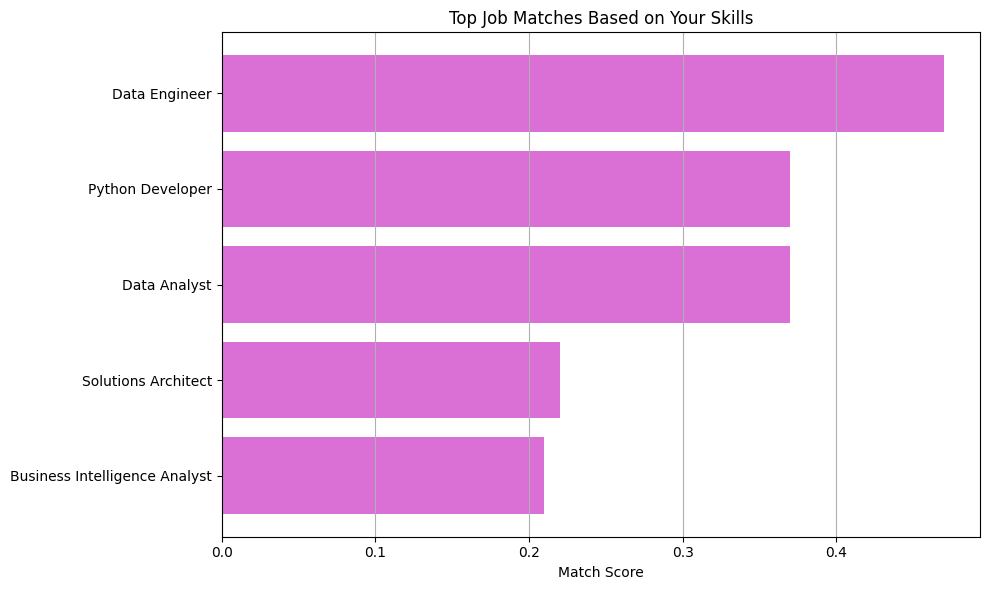

In [35]:
# 🧠 Use extracted skills & About Me from the resume file
my_skills = cv_skills  # From extract_comma_separated_skills(resume_text)
my_about_me = extract_about_me(resume_text)

# 📊 Run similarity analysis on all job roles
results_df, about_me_tip = analyze_cv_and_suggest(my_skills, my_about_me, jobs.copy(), vectorizer)

# 🔝 Identify best-fit branches based on job titles
top_jobs = results_df.sort_values(by="Match Score", ascending=False).head(5)
top_job_titles = top_jobs["Job Title"].tolist()

# 💬 Present career branch recommendation to user
print("🎯 Based on your resume, you're highly suited for roles like:")
for i, title in enumerate(top_job_titles, 1):
    print(f"{i}. {title}")

# 📊 Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(top_jobs['Job Title'][::-1], top_jobs['Match Score'][::-1], color='orchid')
plt.xlabel('Match Score')
plt.title('Top Job Matches Based on Your Skills')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


